In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels import api as sm
import plotly.subplots as sp
import math
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD

warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")

2025-06-06 07:24:33.455030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749194673.707937      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749194673.780651      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv')
df.head() 

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3020 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
 6   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.3+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3020.000000,3019.000000,3020.000000,3.020000e+03
mean,145.515545,146.681738,144.471597,145.617278,5.773301e+06
std,37.554946,37.613446,37.477641,37.529387,3.192831e+06
min,72.740000,73.940000,69.500000,71.740000,2.542560e+05
25%,116.405000,117.765000,115.490000,116.525000,3.622681e+06
50%,149.610000,150.330000,148.470000,149.315000,4.928852e+06
75%,178.445000,179.762500,177.330000,178.685000,6.965014e+06
max,215.380000,215.900000,214.300000,215.800000,3.077428e+07


In [5]:
print(df.isnull().sum())

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


In [6]:
df = df.dropna()

print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [7]:
df["Date"] = pd.to_datetime(df["Date"])

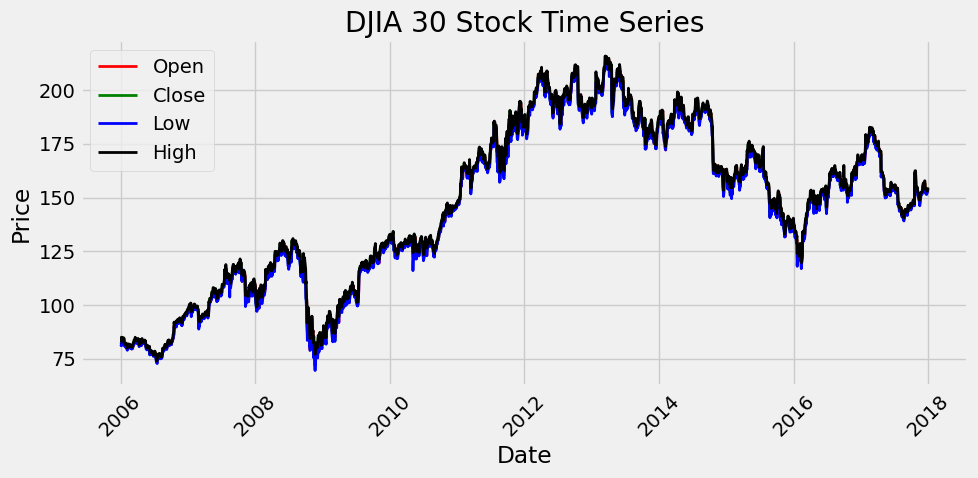

In [8]:
df_IBM = df[df['Name'] == 'IBM']

plt.figure(figsize=(10, 5))
plt.plot(df_IBM['Date'], df_IBM['Open'], color='red', label='Open', linewidth=2)
plt.plot(df_IBM['Date'], df_IBM['Close'], color='green', label='Close', linewidth=2)
plt.plot(df_IBM['Date'], df_IBM['Low'], color='blue', label='Low', linewidth=2)
plt.plot(df_IBM['Date'], df_IBM['High'], color='black', label='High', linewidth=2)

plt.title("DJIA 30 Stock Time Series")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
df.set_index('Date', inplace=True)

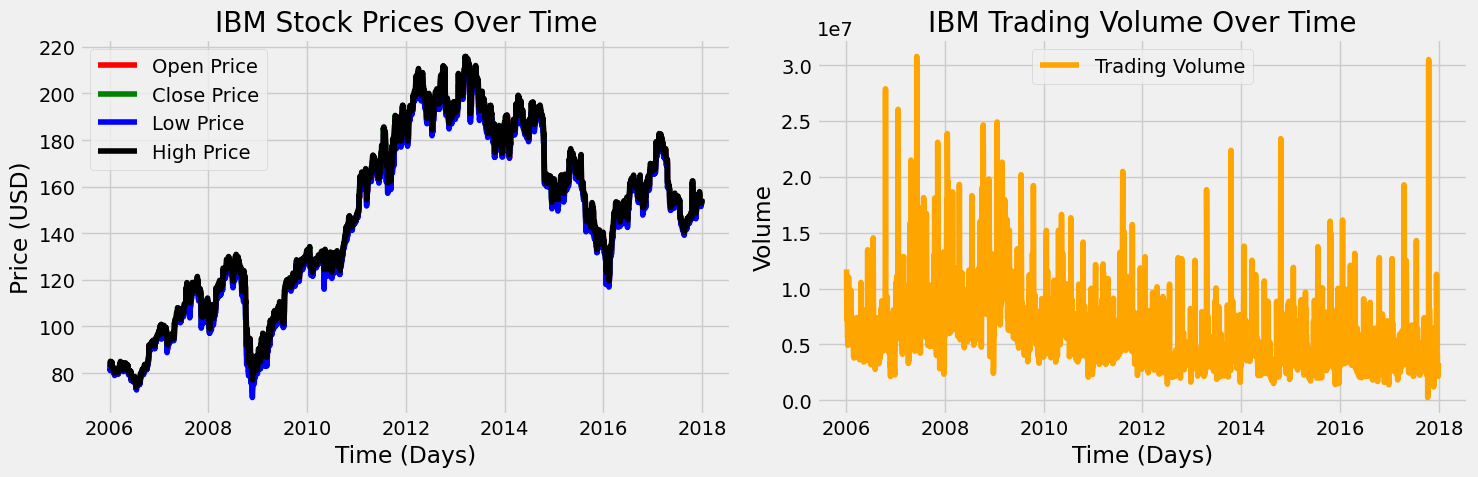

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['Open'], color='red', label='Open Price')
plt.plot(df['Close'], color='green', label='Close Price')
plt.plot(df['Low'], color='blue', label='Low Price')
plt.plot(df['High'], color='black', label='High Price')
plt.title('IBM Stock Prices Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(df['Volume'], color='orange', label='Trading Volume')
plt.title('IBM Trading Volume Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Volume')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [11]:
decomposition_result = seasonal_decompose(df['Close'], model='additive', period=365)

subplot_titles = ['Observed Prices', 'Trend Component', 'Seasonal Component', 'Residuals']

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=subplot_titles)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.observed, 
                         mode='lines', name='Observed Prices',
                         line=dict(color='blue', width=2)), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.trend, 
                         mode='lines', name='Trend',
                         line=dict(color='orange', width=2)), row=2, col=1)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.seasonal, 
                         mode='lines', name='Seasonal',
                         line=dict(color='green', width=2)), row=3, col=1)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.resid, 
                         mode='lines', name='Residual',
                         line=dict(color='red', width=2)), row=4, col=1)

fig.update_layout(height=800, title='Decomposed Analysis of Closing Prices',
                  xaxis_title='Date', yaxis_title='Value', showlegend=True)

fig.show()

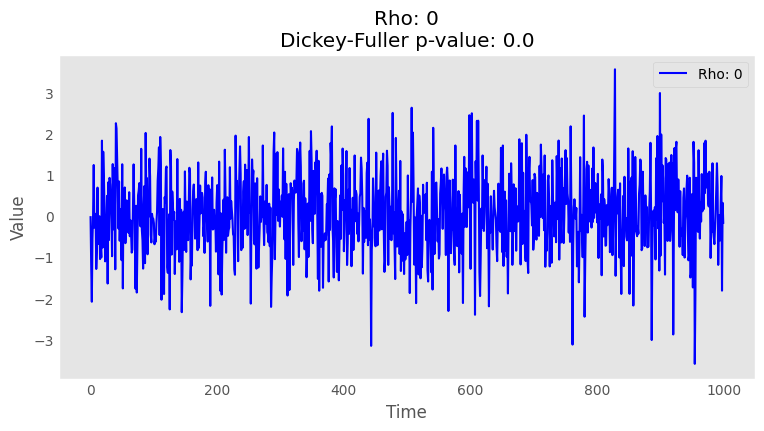

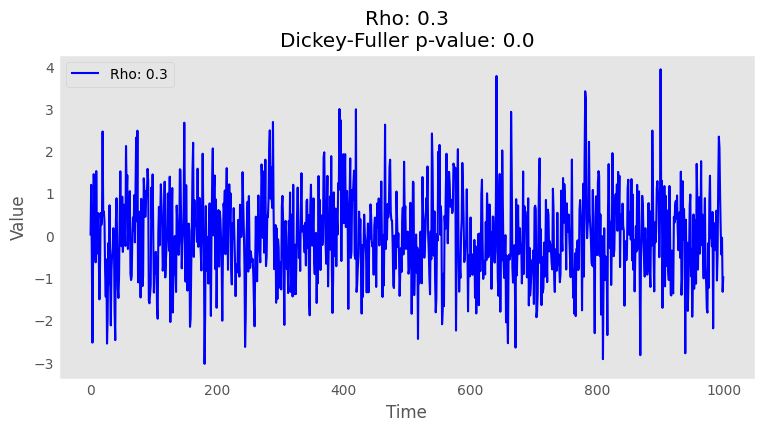

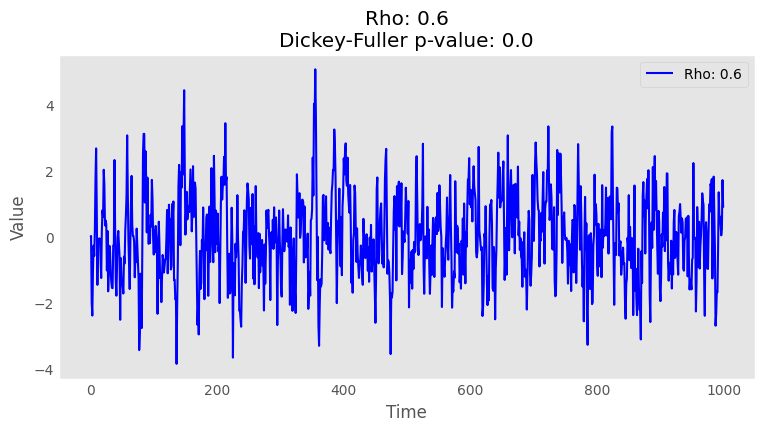

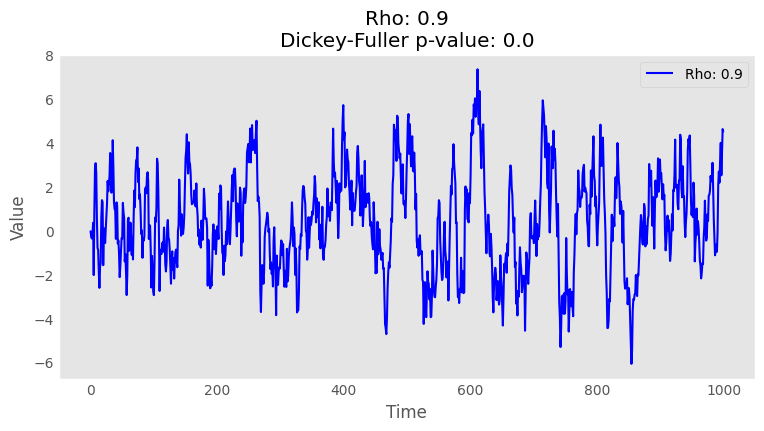

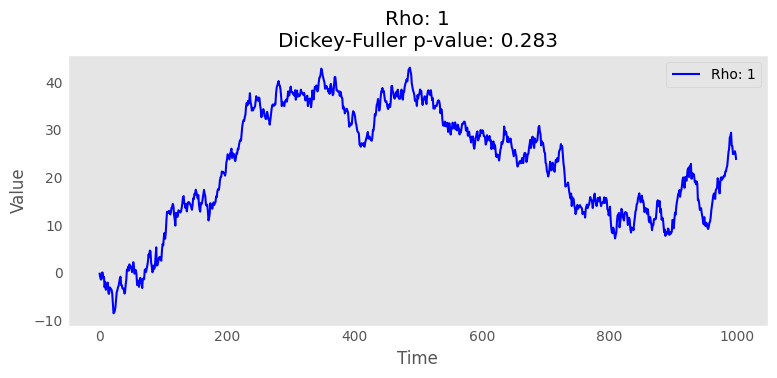

In [12]:
def plotProcess(n_samples=1000, rho=0): 
    w = np.random.normal(size=n_samples)
    x = np.zeros(n_samples)  
    
    for t in range(1, n_samples):  
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('ggplot'):  
        plt.figure(figsize=(8, 4)) 
        plt.plot(x, label=f"Rho: {rho}", linewidth=1.5, color='blue')  
        plt.title(f"Rho: {rho}\nDickey-Fuller p-value: {round(sm.tsa.stattools.adfuller(x)[1], 3)}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()

for rho in [0, 0.3, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

plt.tight_layout() 
plt.show()

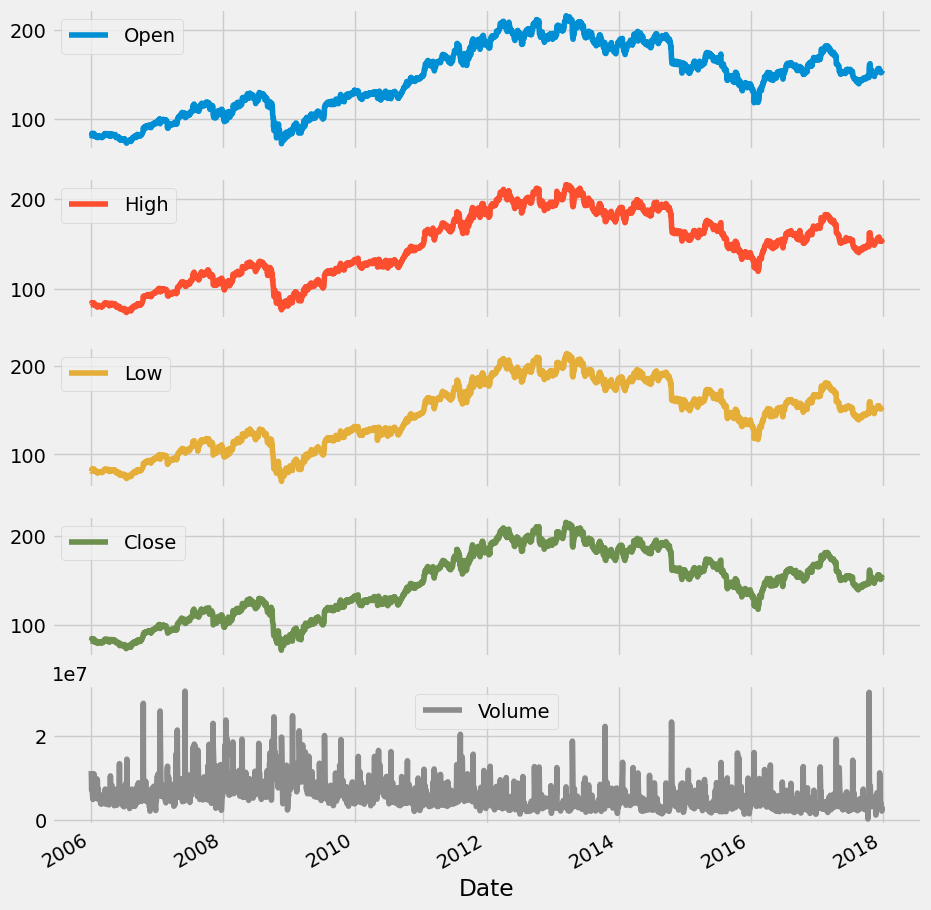

In [13]:
df.plot(subplots=True, figsize=(10,12))
plt.show()

In [14]:
df = df.drop(['Name'], axis=1)

In [15]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200
2006-01-04,82.20,82.50,81.33,81.95,9840600
2006-01-05,81.40,82.90,81.00,82.50,7213500
2006-01-06,83.95,85.03,83.41,84.95,8197400
2006-01-09,84.10,84.25,83.38,83.73,6858200


In [16]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [17]:
train = df[:'2016'].iloc[:,1:2].values
test = df['2017':].iloc[:,1:2].values

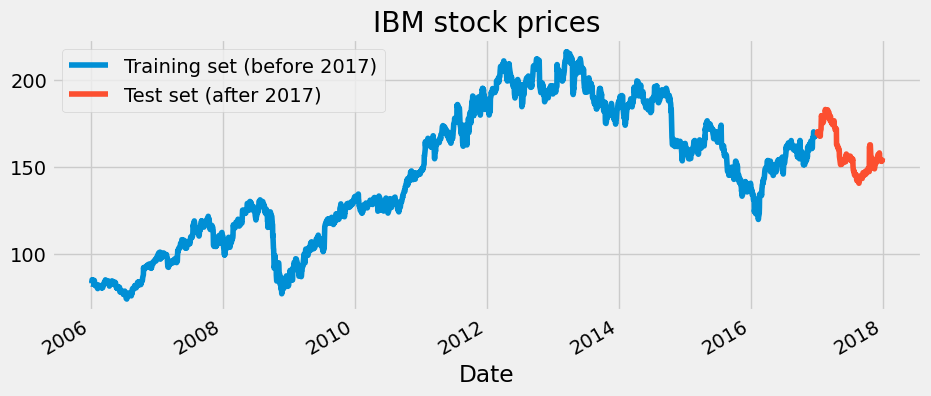

In [18]:
df["High"][:'2016'].plot(figsize=(10,4), legend=True)
df["High"]["2017":].plot(figsize=(10,4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (after 2017)"])
plt.title("IBM stock prices")
plt.show()

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

In [20]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [21]:
time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [22]:
def prepare_and_predict(model, data, scaler, time_step):
    """
    Prepares the input data for the model and makes predictions.

    Parameters:
    model: The trained model (e.g., LSTM_model, RNN_model, etc.)
    data: The original data (Pandas DataFrame) to get the high prices from.
    scaler: The scaler used for normalization (MinMaxScaler).
    time_step: The number of time steps to consider for the LSTM/RNN model.

    Returns:
    predicted_prices: The predicted prices after inverse transformation.
    """
    inputs = data["High"][len(data) - len(test) - time_step:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(time_step, len(inputs)):
        X_test.append(inputs[i-time_step:i, 0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    return predicted_prices

In [23]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  
LSTM_model.add(Dropout(0.3)) 
LSTM_model.add(LSTM(units=100, return_sequences=True))  
LSTM_model.add(Dropout(0.3))  
LSTM_model.add(LSTM(units=100, return_sequences=False))  
LSTM_model.add(Dropout(0.3))  
LSTM_model.add(Dense(units=1))

2025-06-06 07:24:52.636268: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [24]:
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

LSTM_model.fit(X_train, y_train, epochs=15, batch_size=32) 

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - loss: 0.0416
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0040
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0037
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0033
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0030
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0030
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0028
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0029
Epoch 9/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0032
Epoch 10/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0027
Epoch 11/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0024
Epoch 12/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0023
Epoch 13/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0023
Epoch 14/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0021
Epoch 15/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - l

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


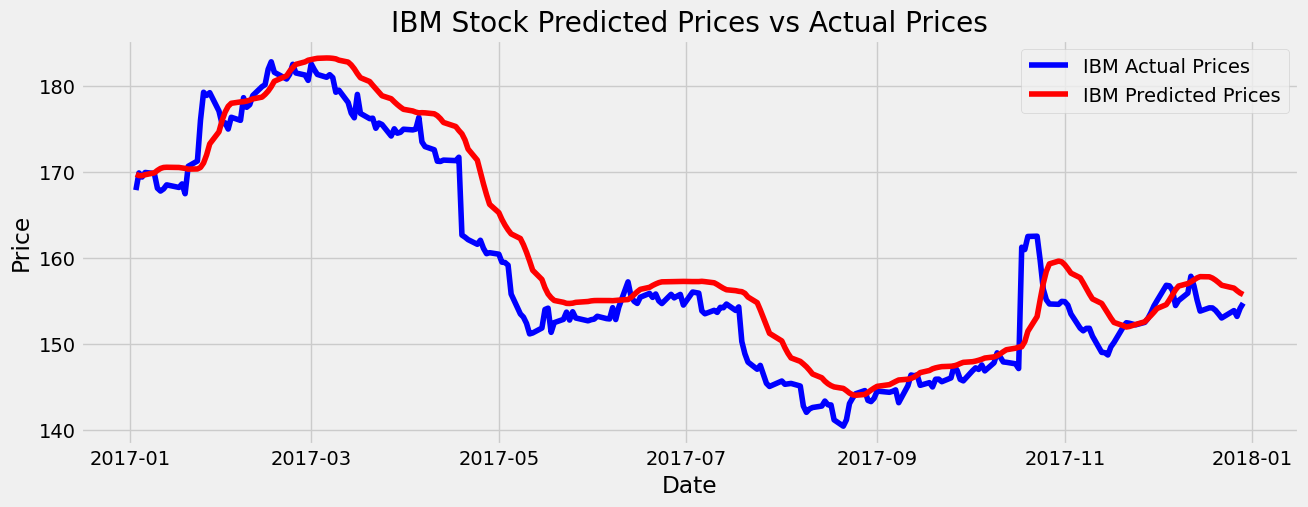

the root mean squared error is : 3.8496174496610163.


In [25]:
predicted_prices = prepare_and_predict(LSTM_model, df, scaler, time_step)

plt.figure(figsize=(14, 5))
plt.plot(df.loc['2017':].index, test, color='blue', label='IBM Actual Prices')
plt.plot(df.loc['2017':].index, predicted_prices, color='red', label='IBM Predicted Prices')
plt.title("IBM Stock Predicted Prices vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

return_rmse(test, predicted_prices)

In [26]:
RNN_model = Sequential()
RNN_model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) 
RNN_model.add(Dropout(0.3))  
RNN_model.add(SimpleRNN(units=100, return_sequences=True))  
RNN_model.add(Dropout(0.3))  
RNN_model.add(SimpleRNN(units=100, return_sequences=False)) 
RNN_model.add(Dropout(0.3))  
RNN_model.add(Dense(units=1))

In [27]:
RNN_model.compile(optimizer='adam', loss='mean_squared_error')

RNN_model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.4049
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1099
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0592
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0341
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0224
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0180
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0126
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0122
Epoch 9/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0090
Epoch 10/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0080
Epoch 11/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0070
Epoch 12/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0059
Epoch 13/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0058
Epoch 14/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0046
Epoch 15/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0044
Epoc

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


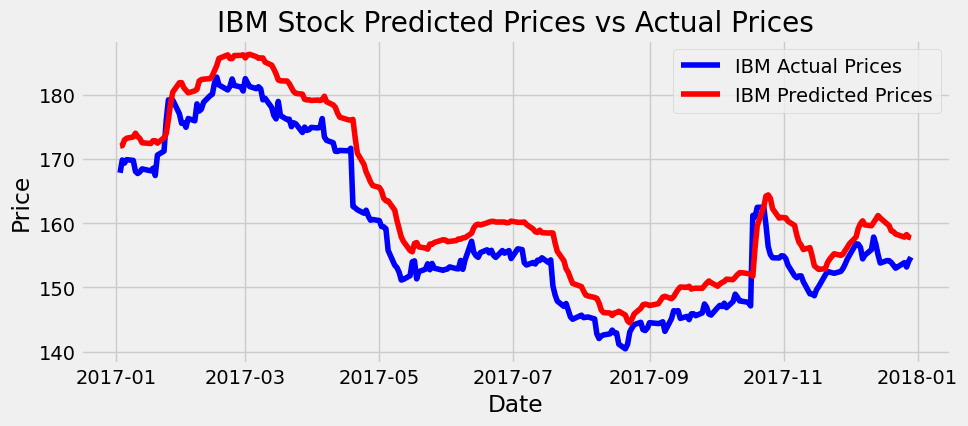

the root mean squared error is : 4.88970541195656.


In [28]:
predicted_prices = prepare_and_predict(RNN_model, df, scaler, time_step)

real_prices = df['2017':].iloc[:, 1:2].values  

plt.figure(figsize=(10, 4))
plt.plot(df.loc['2017':].index, test, color='blue', label='IBM Actual Prices')
plt.plot(df.loc['2017':].index, predicted_prices, color='red', label='IBM Predicted Prices')
plt.title("IBM Stock Predicted Prices vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.show()

return_rmse(test, predicted_prices)

In [29]:
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    return model

GRU_model = create_gru_model((X_train.shape[1], 1))

In [30]:
GRU_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), 
                  loss='mean_squared_error')

GRU_model.fit(X_train, y_train, epochs=15, batch_size=150)  

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 0.1850
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0555
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0285
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0073
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0042
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0037
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0036
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.0033
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 0.0033
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.0031
Epoch 11/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0031
Epoch 12/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0030
Epoch 13/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0029
Epoch 14/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0027
Epoch 15/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - l

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step


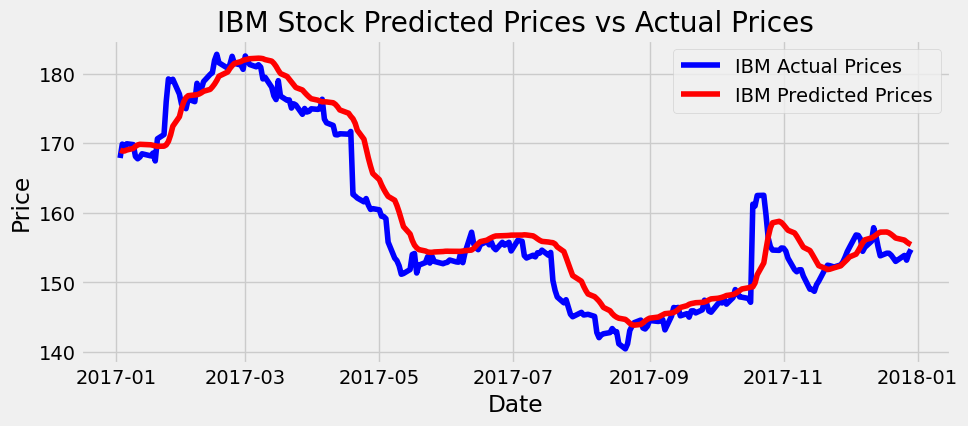

the root mean squared error is : 3.5805084788296133.


In [31]:
predicted_prices = prepare_and_predict(GRU_model, df, scaler, time_step)

real_prices = df['2017':].iloc[:, 1:2].values  

plt.figure(figsize=(10, 4))
plt.plot(df.loc['2017':].index, real_prices, color='blue', label='IBM Actual Prices')  
plt.plot(df.loc['2017':].index, predicted_prices, color='red', label='IBM Predicted Prices')  
plt.title("IBM Stock Predicted Prices vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

return_rmse(test, predicted_prices)